# Intrinsic Curiosity Module (ICM) + A2C on FrozenLake-v1

This notebook details the code implemented in `src/curiosity_a2c/*`. It explains how the code implement Pathak et al. (2017) on FrozenLake-v1.

Curiosity-driven exploration gives agents a dense learning signal when extrinsic rewards vanish. Following Pathak et al. (2017), we pair the Intrinsic Curiosity Module with Advantage Actor-Critic (A2C) on the slippery 8x8 FrozenLake map to show how prediction errors in feature space reshape exploration for the exact code that lives under `src/curiosity_a2c`.

Sections:
1. Rebuild the FrozenLake environment and helper utilities (`envs.py`, `wrappers.py`, `utils.py`).
2. Train the baseline A2C agent with `train_baseline_a2c` to expose the exploration bottleneck under sparse rewards.
3. Drop `ICMModule` + `ICMCallback` into the rollout loop (see `icm_module.py` and `icm_a2c.py`) so the agent optimizes Equations (1)-(7) from Pathak et al., then compare both policies side by side using `compare_models` and `record_episodes`.

## Setup and Imports

The next code cell mirrors what the scripts under `src/curiosity_a2c` do:
- `train_baseline_a2c` from `baseline_a2c.py`
- `train_a2c_with_icm` from `icm_a2c.py`
- `compare_models` from `compare.py`
- `test_model` from `utils.py`
- `record_episodes` from `record_videos.py`

We also import Gymnasium, Stable-Baselines3, Torch, and plotting utilities so the notebook runs the same code paths as the CLI scripts.

----------------------------------------

In [1]:
# Install project dependencies (optional)
# Run this only if your environment is missing packages; it installs the local project and its extras.
import sys, subprocess

cmd = [sys.executable, "-m", "pip", "install", "-e", ".[dev]"]
print(" ".join(cmd))
subprocess.run(cmd, check=False)


/home/arkinsas/fall2025/rl/mini-curiosity/.venv/bin/python -m pip install -e .[dev]
Obtaining file:///home/arkinsas/fall2025/rl/mini-curiosity
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for curiosity-a2c (pyproject.toml): started
  Building editable for curiosity-a2c (pyproject.toml): finished with status 'done'
  Created wheel for curiosity-a2c: filename=curiosity_a2c-0.1.0-0.editable-py3-none-any.whl size=3296 sha256=ae78f94060c5e39f8acdbb71c2567a8547cc1851716b439934ecb09479e4103e
  Stored in directory: /tmp/pip-ephem-w


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


CompletedProcess(args=['/home/arkinsas/fall2025/rl/mini-curiosity/.venv/bin/python', '-m', 'pip', 'install', '-e', '.[dev]'], returncode=0)

In [2]:
import torch
import matplotlib.pyplot as plt

from torch.optim import Adam

from curiosity_a2c.envs import make_frozenlake_env
from curiosity_a2c.utils import make_env, test_model
from curiosity_a2c.icm_module import ICMModule, ICMCallback
from curiosity_a2c.baseline_a2c import train_baseline_a2c
from curiosity_a2c.icm_a2c import train_a2c_with_icm
from curiosity_a2c.compare import compare_models


## 1. Environment Setup

`curiosity_a2c.envs.make_frozenlake_env` is the single entry point every script imports. It always builds `gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True, render_mode="rgb_array")`, wraps it with `FrozenLakePixelWrapper` (see `wrappers.py`) to resize frames to 42x42 RGB tensors (CHW layout), and then optionally attaches a `Monitor` for episode stats/log files. The helper ignores the `render_mode` kwarg because the wrapper grabs frames directly, so any rendering (RGB array vs. human) is handled later when we build `DummyVecEnv` factories.

`utils.make_env` is a thin alias used throughout `baseline_a2c.py`, `icm_a2c.py`, `record_videos.py`, and `utils.test_model`. When we spin up vectorized environments in the notebook we call the exact same factory, which means wrappers, observation shapes, and seeding logic always match the scripts. Use this section to instantiate env factories, seeds, log directories, and to demonstrate how to switch between monitor vs. non-monitor runs-everything else in the notebook reuses those handles.

----------------------------------------

In [3]:
# Instantiate the packaged FrozenLake env and inspect spaces
env = make_env()
obs_space, action_space = env.observation_space, env.action_space

obs, _ = env.reset()
print("Observation space:", obs_space)
print("Action space:", action_space)
print("Initial observation shape:", obs.shape)

env.close()


Observation space: Box(0, 255, (3, 42, 42), uint8)
Action space: Discrete(4)
Initial observation shape: (3, 42, 42)


/home/arkinsas/fall2025/rl/mini-curiosity/.venv/lib64/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


## 2. Curiosity-Driven Exploration (Pathak et al., 2017)

`src/curiosity_a2c/icm_module.py` implements the Intrinsic Curiosity Module  from the paper. `ICMModule` exposes the gives encoder, inverse model, forward model, and intrinsic reward that the rest of the package imports.

The policy objective from Equation (1) stays untouched:
$$
\max_{\theta_P} \mathbb{E}_{\pi(\cdot;\theta_P)} \Bigg[\sum_t r_t\Bigg], \tag{1}
$$
with $r_t = r_t^e + r_t^i$ as implemented when `ICMCallback` augments rewards inside `icm_module.py`.

**Inverse dynamics encoder (Equations 2-3).** `ICMModule.inverse_model` predicts the action label exactly as
$$
\hat{a}_t = g(s_t, s_{t+1}; \theta_I), \tag{2}
$$
$$
\min_{\theta_I} \mathcal{L}_I(\hat{a}_t, a_t). \tag{3}
$$
Those correspond to the cross-entropy loss computed in `ICMModule.forward` whenever the callback processes rollout buffers.

**Forward dynamics model (Equations 4-5).** `ICMModule.forward_model` predicts the next feature vector instead of pixels:
$$
\hat{\phi}(s_{t+1}) = f(\phi(s_t), a_t; \theta_F), \tag{4}
$$
$$
\mathcal{L}_F = \tfrac{1}{2} \lVert \hat{\phi}(s_{t+1}) - \phi(s_{t+1}) \rVert_2^2. \tag{5}
$$

**Intrinsic reward (Equation 6).** `ICMCallback` grabs the prediction error returned by `ICMModule` and adds it to the reward tensor before A2C updates:
$$
 r_t^i = \tfrac{\eta}{2} \lVert \hat{\phi}(s_{t+1}) - \phi(s_{t+1}) \rVert_2^2. \tag{6}
$$

**Joint optimization (Equation 7).** The callback stitches everything together while `train_a2c_with_icm` injects the callback during `model.learn`:
$$
\min_{\theta_P,\theta_I,\theta_F} -\lambda\, \mathbb{E}_\pi \Big[\sum_t r_t\Big] + (1-\beta)\mathcal{L}_I + \beta \mathcal{L}_F. \tag{7}
$$
Paper defaults (`beta = 0.2`, `lambda = 0.1`, `eta = 0.01`) are used as the default values.


In [4]:
# Build the Intrinsic Curiosity Module using the env spaces
icm_module = ICMModule(
    observation_space=obs_space,
    action_space=action_space,
    beta=0.2,
    eta=0.01,
)
icm_module


ICMModule(
  (feature_encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ELU(alpha=1.0)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ELU(alpha=1.0)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ELU(alpha=1.0)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (feature_projection): Linear(in_features=288, out_features=288, bias=True)
  (inverse_model): Sequential(
    (0): Linear(in_features=576, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=4, bias=True)
  )
  (forward_model): Sequential(
    (0): Linear(in_features=292, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=288, bias=True)
  )
)

## 3. ICM Callback for Training

`ICMCallback` (defined in `icm_module.py`) is the training script hands to SB3. Each rollout:
1. Pulls `(s_t, a_t, s_{t+1})` from the `A2C` rollout buffer.
2. Feeds them through `ICMModule.forward` to compute `L_I`, `L_F`, and `intrinsic_reward`.
3. Forms `icm_loss = (1-beta) * L_I + beta * L_F` (same math that lives in the callback).
4. Adds `r_t^i` from Equation (6) to the vectorized `VecNormalize` reward stream before the policy update.

Because this is the same class imported by both the CLI (`icm_a2c.py`) and the notebook, any edits to `ICMCallback` immediately show up here.

----------------------------------------

In [5]:
# Wire up the ICM optimizer and callback (the same objects used during training)
icm_optimizer = Adam(icm_module.parameters(), lr=1e-3)
icm_callback = ICMCallback(icm_module, icm_optimizer, lambda_weight=0.1)
icm_callback


## 4. Baseline A2C Training

`train_baseline_a2c` (from `baseline_a2c.py`) documents the vanilla A2C stack that lives in the repo:
- Creates `DummyVecEnv([make_env] * n_envs)` for training and another single-env copy for evaluation.
- Wraps them with `VecNormalize`, setting `norm_obs=False` and `norm_reward=True` on the training side so only rewards are normalized (mirrors the script).
- Registers `EvalCallback` (10 evaluation episodes every 5k steps) and `CheckpointCallback` (save every 10k steps) that write into `logs/<save_path>/`.
- Calls `A2C("CnnPolicy", ...)` with `use_rms_prop=True`, `normalize_advantage=True`, and the default hyperparameters from the script.

The code cell under this heading calls the function directly, so its keyword arguments (learning rate, entropy coefficient, etc.) stay aligned with the Python source.

----------------------------------------

In [ ]:
# Baseline A2C training configuration shared with the script
BASELINE_CONFIG = dict(
    total_timesteps=200000,
    n_envs=4,
    learning_rate=7e-4,
    ent_coef=0.01,
)
BASELINE_CONFIG


{'total_timesteps': 1000,
 'n_envs': 4,
 'learning_rate': 0.0007,
 'ent_coef': 0.01}

## 5. A2C with ICM Training

`train_a2c_with_icm` (from `icm_a2c.py`) mirrors the baseline but wires in the intrinsic curiosity machinery:
- Builds the same `DummyVecEnv`/`VecNormalize` pair.
- Instantiates `ICMModule` with the env observation and action spaces (so the encoder automatically picks the Conv net path) and places it on the SB3 policy device.
- Sets up `ICMCallback`, passing in an `Adam` optimizer, `lambda_weight`, and the curiosity scalars (`icm_beta`, `icm_eta`). The callback mutates the rollout buffer rewards exactly like the script.
- Appends `[icm_callback, eval_callback, checkpoint_callback]` to `model.learn` and, after training, saves `*_final.zip`, the ICM weights (`*_icm.pth`), and the VecNormalize stats (`*_vecnormalize.pkl`).

Because the notebook calls the actual function, any change you make inside `icm_a2c.py` (e.g., toggling beta defaults or optimizer settings) automatically propagates here.

----------------------------------------

In [ ]:
# A2C + ICM training configuration (mirrors icm_a2c.py defaults)
ICM_CONFIG = dict(
    total_timesteps=200000,
    n_envs=4,
    learning_rate=7e-4,
    ent_coef=0.01,
    icm_lr=1e-3,
    icm_beta=0.2,
    icm_eta=0.01,
)
ICM_CONFIG


{'total_timesteps': 1000,
 'n_envs': 4,
 'learning_rate': 0.0007,
 'ent_coef': 0.01,
 'icm_lr': 0.001,
 'icm_beta': 0.2,
 'icm_eta': 0.01}

## 6. Testing and Comparison Utilities

Everything under this heading is just re-exporting the helpers from `src/curiosity_a2c`:
- `utils.test_model` loads `.zip` checkpoints with `A2C.load`, restores `VecNormalize` stats if present, and reports reward/length metrics.
- `compare.compare_models` wraps two `test_model` calls, prints side-by-side statistics, and runs a SciPy t-test (same logic as `python -m curiosity_a2c.compare`).
- `record_videos.record_episodes` / `record_single_episode` reuse the `make_env` factory plus Gymnasium's `RecordVideo` wrapper to log MP4s.

The notebook cells call these functions without modification, so the documentation here reflects the true CLI behavior.

----------------------------------------

In [14]:
# Utilities come from curiosity_a2c.utils and curiosity_a2c.compare (imported above).
# Plot helper remains local to the notebook.

def plot_comparison(results):
    """Plot comparison between baseline and ICM models."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].boxplot(
        [results['baseline']['rewards'], results['icm']['rewards']],
        labels=['Baseline A2C', 'A2C + ICM'],
    )
    axes[0].set_ylabel('Episode Reward')
    axes[0].set_title('Reward Distribution Comparison')
    axes[0].grid(True, alpha=0.3)

    axes[1].boxplot(
        [results['baseline']['lengths'], results['icm']['lengths']],
        labels=['Baseline A2C', 'A2C + ICM'],
    )
    axes[1].set_ylabel('Episode Length (steps)')
    axes[1].set_title('Episode Length Comparison')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


## 7. Train Models

The training cells simply dispatch to `train_baseline_a2c(...)` and `train_a2c_with_icm(...)`. Artifacts land in `models/<run>` and `logs/<run>` exactly as in the scripts, and the returned SB3 objects are identical to what the CLI would produce. Adjust arguments here (timesteps, seed, reward normalization) the same way you would when editing the Python functions.

----------------------------------------

In [15]:
# Train Baseline A2C
baseline_model, baseline_env = train_baseline_a2c(**BASELINE_CONFIG)


Using cuda device

Training Baseline A2C on FrozenLake-v1
Total timesteps: 1,000
Number of environments: 4
Learning rate: 0.0007
Entropy coefficient: 0.01

Logging to ./logs/models/baseline/a2c_frozenlake_baseline/tensorboard/A2C_5


Output()


Training completed!
Model saved to: models/baseline/a2c_frozenlake_baseline_final.zip
Normalization stats saved to: models/baseline/a2c_frozenlake_baseline_vecnormalize.pkl



In [16]:
# Train A2C with ICM
icm_model, icm_module, icm_env = train_a2c_with_icm(**ICM_CONFIG)


Using cuda device

Training A2C with ICM on FrozenLake-v1
Total timesteps: 1,000
Number of environments: 4
A2C Learning rate: 0.0007
ICM Learning rate: 0.001
ICM Beta (forward weight): 0.2
ICM Eta (reward scale): 0.01
Entropy coefficient: 0.01

Logging to ./logs/models/icm/a2c_frozenlake_icm/tensorboard/A2C_7


Output()


Training completed!
A2C Model saved to: models/icm/a2c_frozenlake_icm_final.zip
ICM Module saved to: models/icm/a2c_frozenlake_icm_icm.pth



## 8. Compare Results

This section calls `compare_models(baseline_path, icm_path, n_episodes)` from `compare.py`. Paths default to `models/baseline/a2c_frozenlake_baseline_final` and `models/icm/a2c_frozenlake_icm_final`, which match the save locations used in both training scripts. The printed summary (means, stds, success rates, t-test) is identical to running `python -m curiosity_a2c.compare`.

----------------------------------------

In [17]:
# Compare both models
comparison_results = compare_models(
    "models/baseline/a2c_frozenlake_baseline_final",
    "models/icm/a2c_frozenlake_icm_final",
    n_episodes=50
)


COMPARING BASELINE A2C vs A2C + ICM

[1/2] Testing Baseline A2C...

Testing BASELINE A2C Model

Episode 1: Reward = 1.00, Steps = 42
Episode 2: Reward = 0.00, Steps = 100
Episode 3: Reward = 0.00, Steps = 5
Episode 4: Reward = 0.00, Steps = 14
Episode 5: Reward = 0.00, Steps = 100
Episode 6: Reward = 0.00, Steps = 11
Episode 7: Reward = 0.00, Steps = 9
Episode 8: Reward = 0.00, Steps = 100
Episode 9: Reward = 0.00, Steps = 100
Episode 10: Reward = 1.00, Steps = 48
Episode 11: Reward = 0.00, Steps = 8
Episode 12: Reward = 0.00, Steps = 7
Episode 13: Reward = 0.00, Steps = 100
Episode 14: Reward = 0.00, Steps = 7
Episode 15: Reward = 0.00, Steps = 7
Episode 16: Reward = 0.00, Steps = 14
Episode 17: Reward = 0.00, Steps = 7
Episode 18: Reward = 0.00, Steps = 10
Episode 19: Reward = 0.00, Steps = 11
Episode 20: Reward = 0.00, Steps = 13
Episode 21: Reward = 0.00, Steps = 5
Episode 22: Reward = 0.00, Steps = 100
Episode 23: Reward = 0.00, Steps = 13
Episode 24: Reward = 1.00, Steps = 66
Ep

/tmp/ipykernel_484428/840339319.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(
/tmp/ipykernel_484428/840339319.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(


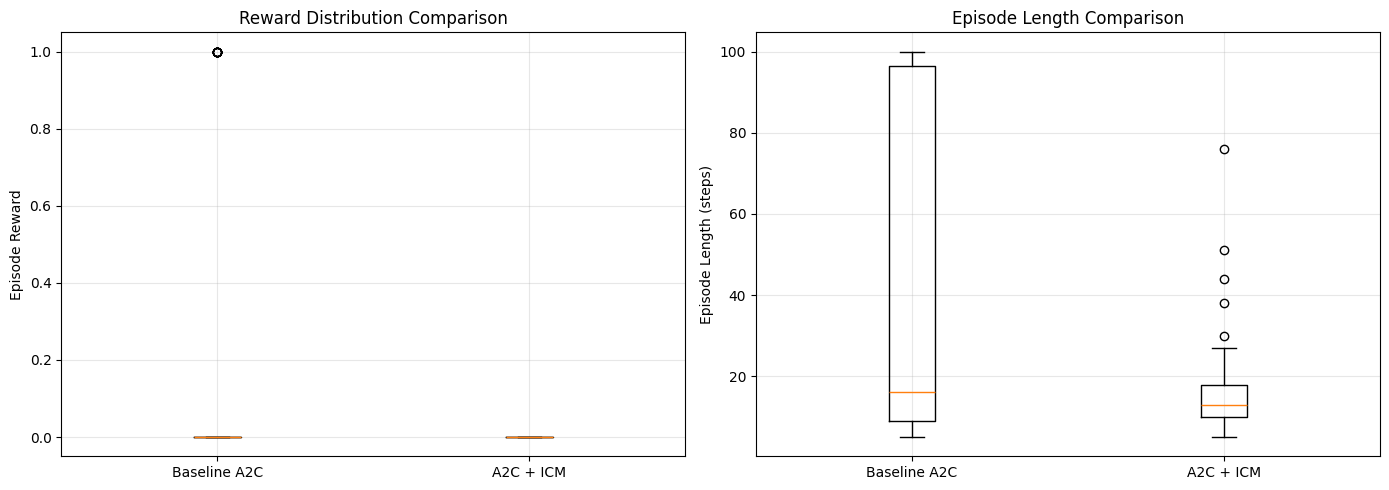

In [18]:
# Visualize comparison
plot_comparison(comparison_results)

## 9. Test Individual Models

We import `test_model` from `utils.py` and call it directly for whichever checkpoint you want to inspect. Because this is the same helper used by `compare_models` and the CLI utilities, the evaluation logic (deterministic actions, optional rendering, VecNormalize restoration) stays consistent across notebook and scripts.

----------------------------------------

In [19]:
# Test baseline model
baseline_rewards, baseline_lengths = test_model(
    "models/baseline/a2c_frozenlake_baseline_final",
    n_episodes=10,
    model_type='baseline'
)


Testing BASELINE A2C Model

Episode 1: Reward = 0.00, Steps = 100
Episode 2: Reward = 1.00, Steps = 62
Episode 3: Reward = 0.00, Steps = 16
Episode 4: Reward = 0.00, Steps = 100
Episode 5: Reward = 0.00, Steps = 14
Episode 6: Reward = 0.00, Steps = 15
Episode 7: Reward = 0.00, Steps = 7
Episode 8: Reward = 0.00, Steps = 9
Episode 9: Reward = 0.00, Steps = 6
Episode 10: Reward = 0.00, Steps = 13

Test Results (10 episodes)
Average Reward: 0.10 (+/- 0.30)
Average Steps: 34.20 (+/- 36.28)
Success Rate: 10.0%



In [20]:
# Test ICM model
icm_rewards, icm_lengths = test_model(
    "models/icm/a2c_frozenlake_icm_final",
    n_episodes=10,
    model_type='icm'
)


Testing ICM A2C Model

Episode 1: Reward = 0.00, Steps = 17
Episode 2: Reward = 0.00, Steps = 17
Episode 3: Reward = 0.00, Steps = 15
Episode 4: Reward = 0.00, Steps = 12
Episode 5: Reward = 0.00, Steps = 17
Episode 6: Reward = 0.00, Steps = 17
Episode 7: Reward = 0.00, Steps = 13
Episode 8: Reward = 0.00, Steps = 22
Episode 9: Reward = 0.00, Steps = 12
Episode 10: Reward = 0.00, Steps = 7

Test Results (10 episodes)
Average Reward: 0.00 (+/- 0.00)
Average Steps: 14.90 (+/- 3.88)
Success Rate: 0.0%



## 11. Key Hyperparameters

These knobs surface directly on the functions we call:

**A2C knobs (`train_baseline_a2c`).** `total_timesteps`, `n_envs`, `learning_rate`, `n_steps`, `gamma`, `gae_lambda`, `ent_coef`, `vf_coef`, `max_grad_norm`, plus the checkpoint/log paths. Changing them here is equivalent to passing new values into the Python function.

**ICM knobs (`train_a2c_with_icm`).**
- `icm_lr`: learning rate for the `Adam` optimizer inside `icm_a2c.py`.
- `icm_beta`: weighs forward vs. inverse loss inside `ICMModule` (Equation 7).
- `icm_eta`: scales the intrinsic reward produced by `ICMModule`.
- `lambda_weight`: multiplier passed to `ICMCallback` (placeholder similar to the paper's lambda term).

**Reward composition + logging.** Reward normalization and checkpoint directories come straight from the Python scripts: `VecNormalize` makes intrinsic and extrinsic returns more stable, and everything is saved under `models/` + `logs/`. Keep `icm_eta <= 0.01` if you want intrinsic rewards to stay comparable to FrozenLake's extrinsic {0, 1} signal.

----------------------------------------

## 10. Visualize Training with TensorBoard


In [22]:
# Launch TensorBoard inside the notebook
%load_ext tensorboard
%tensorboard --logdir logs --port 6006


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 496233), started 0:01:35 ago. (Use '!kill 496233' to kill it.)